In [ ]:
#Importamos las librerías necesarias
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
import joblib

c:\Users\ERICF\anaconda3\envs\Python3-12-9\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Cargamos los datos
df = pd.read_csv("CONCATE_Data.csv")

# Convertir fechas a datetime con dayfirst explícito
df["fecha"] = pd.to_datetime(df["fecha"], format="%d/%m/%Y", errors="coerce", dayfirst=True)
df["fecha_nacimiento"] = pd.to_datetime(df["fecha_nacimiento"], format="%d/%m/%Y", errors="coerce", dayfirst=True)
df["fecha_alta"] = pd.to_datetime(df["fecha_alta"], format="%d/%m/%Y", errors="coerce", dayfirst=True)


# Calcular edad y años de historial
hoy = pd.Timestamp.today()
df["edad"] = df["fecha_nacimiento"].apply(lambda x: hoy.year - x.year - ((hoy.month, hoy.day) < (x.month, x.day)) if pd.notnull(x) else None)
df["historial"] = df["fecha_alta"].apply(lambda x: hoy.year - x.year - ((hoy.month, hoy.day) < (x.month, x.day)) if pd.notnull(x) else None)

# Día del año desde el 1 de enero
df["dia_del_ano"] = df["fecha"].dt.dayofyear

# Normalización de género
df["genero"] = df["genero"].str.lower().str.strip().replace({
    "f": 0, "femenino": 0,
    "m": 1, "masculino": 1
})

# Factorizar tipo_venta, comercio, giro_comercio, actividad_empresarial
df["tipo_venta"], map_tipo_venta = pd.factorize(df["tipo_venta"])
df["comercio"], map_comercio = pd.factorize(df["comercio"])
df["giro_comercio"], map_giro_comercio = pd.factorize(df["giro_comercio"])
df["actividad_empresarial"], map_actividad = pd.factorize(df["actividad_empresarial"])

In [ ]:
df.isnull().sum()  # Verificar si hay valores nulos

id                          0
fecha                       0
comercio                    0
giro_comercio               0
tipo_venta                  0
monto                       0
fecha_nacimiento         2032
fecha_alta                  0
id_municipio                0
id_estado                   0
tipo_persona                0
genero                      0
actividad_empresarial       0
edad                     2032
historial                   0
dia_del_ano                 0
dtype: int64

In [ ]:
# Guardar los datos preprocesados
df.to_csv('datata.csv', index=False)

In [ ]:
#Cargar los datos preprocesados
df = pd.read_csv("datata.csv")

# Seleccionar columnas para el modelo
features = [
    'edad', 'historial', 'comercio', 'giro_comercio', 'tipo_venta',
    'dia_del_ano', 'genero', 'actividad_empresarial', 'id_municipio', 'id_estado'
]

# Crear copia del dataframe y eliminar nulos
df_model = df[features + ['monto', 'fecha', 'id']].dropna().copy()

# Asegurar que 'fecha' esté en formato datetime
df_model['fecha'] = pd.to_datetime(df_model['fecha'])

# Crear variables objetivo
df_model['y_monto'] = df_model['monto']
df_model['y_tiempo'] = df_model.groupby('id')['fecha'].diff().dt.days.fillna(0)
df_model['y_recompra'] = (df_model['y_tiempo'] > 0).astype(int)

# Separar X e y
X = df_model[features]
y = df_model[['y_monto', 'y_tiempo', 'y_recompra']]

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y['y_recompra']
)

# Escalado de variables numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(float))
X_test_scaled = scaler.transform(X_test.select_dtypes(float))

# Actualizar variables numéricas en X_train y X_test
X_train.update(pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.select_dtypes(float).columns))
X_test.update(pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.select_dtypes(float).columns))

# Entrenar modelos LightGBM
clf_recompra = lgb.LGBMClassifier(n_estimators=200, learning_rate=0.05)
clf_recompra.fit(X_train, y_train['y_recompra'])

reg_tiempo = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05)
reg_tiempo.fit(X_train, y_train['y_tiempo'])

reg_monto = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05)
reg_monto.fit(X_train, y_train['y_monto'])

"Modelos entrenados correctamente: clasificación (recompra), regresión (tiempo), regresión (monto)"


[LightGBM] [Info] Number of positive: 148821, number of negative: 126026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 274847, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.541469 -> initscore=0.166256
[LightGBM] [Info] Start training from score 0.166256
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 274847, number of used features: 10
[LightGBM] [Info] Start training from score 1.127766
[LightGBM] [Info] Auto-choosing row-

'Modelos entrenados correctamente: clasificación (recompra), regresión (tiempo), regresión (monto)'

In [ ]:
# Analizamos las metricas de los modelos
y_pred_class = clf_recompra.predict(X_test)
y_prob_class = clf_recompra.predict_proba(X_test)[:, 1]

print("Accuracy:", round(accuracy_score(y_test['y_recompra'], y_pred_class), 3))
print("Precision:", round(precision_score(y_test['y_recompra'], y_pred_class), 3))
print("Recall:", round(recall_score(y_test['y_recompra'], y_pred_class), 3))
print("F1 Score:", round(f1_score(y_test['y_recompra'], y_pred_class), 3))
print("ROC AUC:", round(roc_auc_score(y_test['y_recompra'], y_prob_class), 3))

Accuracy: 0.618
Precision: 0.613
Recall: 0.794
F1 Score: 0.692
ROC AUC: 0.658


In [ ]:
print(y_test)

        y_monto  y_tiempo  y_recompra  comercio
183977    17.01       0.0           0         3
182872     6.67       1.0           1        41
176187     2.77       0.0           0         5
182368    19.77       1.0           1        27
244874     3.69       2.0           1        35
...         ...       ...         ...       ...
79900      2.65       0.0           0         3
149443     9.78       1.0           1        25
278697    53.09       2.0           1        26
197724     2.48       1.0           1         3
338792    16.96       0.0           0         5

[68712 rows x 4 columns]


In [ ]:
# Definir el modelo base
modelo = lgb.LGBMRegressor()

# Definir la grilla de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'min_child_samples': [20, 50],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

# GridSearch con validación cruzada
grid_search = GridSearchCV(
    estimator=modelo,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # puedes usar también: 'r2', 'neg_mean_squared_error'
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Ejecutar búsqueda
grid_search.fit(X_train, y_train['y_monto'])

# Mostrar mejores hiperparámetros encontrados
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

# Mejor modelo
mejor_modelo = grid_search.best_estimator_

In [ ]:
# Para clasificación: y_recompra
def objective_clf(trial):
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "verbosity": -1
    }

    clf = lgb.LGBMClassifier(**params, n_estimators=100)
    score = cross_val_score(clf, X_train, y_train['y_recompra'], cv=StratifiedKFold(5), scoring='roc_auc').mean()
    return score

study_clf = optuna.create_study(direction="maximize")
study_clf.optimize(objective_clf, n_trials=50)
best_clf_params = study_clf.best_params

c:\Users\ERICF\anaconda3\envs\Python3-12-9\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-05-24 18:46:31,077] A new study created in memory with name: no-name-eaefc1f2-5427-44fa-9868-689d3e76af6f
C:\Users\ERICF\AppData\Local\Temp\ipykernel_3556\834084260.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\ERICF\AppData\Local\Temp\ipykernel_3556\834084260.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": t

In [ ]:
def objective_reg(trial, target):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "verbosity": -1
    }

    reg = lgb.LGBMRegressor(**params, n_estimators=100)
    score = cross_val_score(reg, X_train, y_train[target], cv=KFold(5), scoring='neg_root_mean_squared_error').mean()
    return -score  # Minimize RMSE

# Para tiempo
study_tiempo = optuna.create_study(direction="minimize")
study_tiempo.optimize(lambda trial: objective_reg(trial, 'y_tiempo'), n_trials=100)
best_params_tiempo = study_tiempo.best_params

# Para monto
study_monto = optuna.create_study(direction="minimize")
study_monto.optimize(lambda trial: objective_reg(trial, 'y_monto'), n_trials=100)
best_params_monto = study_monto.best_params

[I 2025-05-24 18:53:05,240] A new study created in memory with name: no-name-b795ba36-87b8-4f7a-ae75-b6ede24d3230
C:\Users\ERICF\AppData\Local\Temp\ipykernel_3556\3497384710.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\ERICF\AppData\Local\Temp\ipykernel_3556\3497384710.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_fraction", 0.6, 1.0),
C:\Users\ERICF\AppData\Local\Temp\ipykernel_3556\3497384710.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/release

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 148821, number of negative: 126026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 702
[LightGBM] [Info] Number of data points in the train set: 274847, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.541469 -> initscore=0.166256
[LightGBM] [Info] Start training from score 0

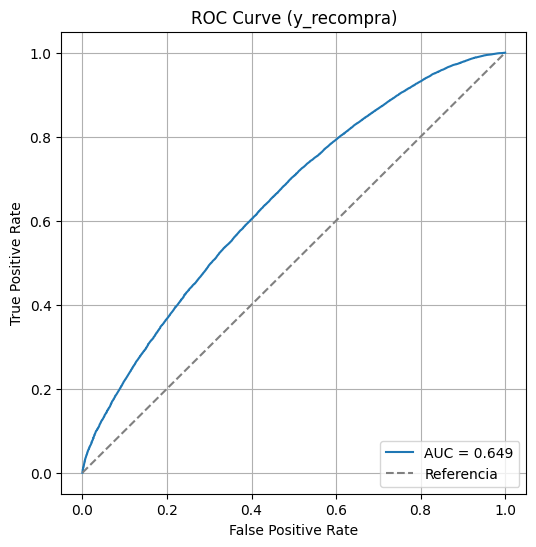

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)

# -------------------------------
# 1) Cargar y preparar datos
# -------------------------------
df = pd.read_csv("datata.csv")

features = [
    'edad', 'historial', 'comercio', 'giro_comercio', 'tipo_venta',
    'dia_del_ano', 'genero', 'actividad_empresarial', 'id_municipio', 'id_estado'
]

df_model = df[features + ['monto', 'fecha', 'id']].dropna().copy()
df_model['fecha'] = pd.to_datetime(df_model['fecha'])
df_model['y_monto']    = df_model['monto']
df_model['y_tiempo']   = df_model.groupby('id')['fecha'].diff().dt.days.fillna(0)
df_model['y_recompra'] = (df_model['y_tiempo'] > 0).astype(int)

# -------------------------------
# 2) División en X e y
# -------------------------------
X = df_model[features]
y = df_model['y_recompra']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Escalado de variables numéricas
scaler = StandardScaler()
num_cols = X_train.select_dtypes(include=[float, int]).columns
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])

# -------------------------------
# 3) Entrenar modelo de clasificación
# -------------------------------
clf_recompra = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.05, random_state=42,bagging_fraction=0.8,bagging_freq=1)
clf_recompra.fit(X_train, y_train)

# -------------------------------
# 4) Evaluación y métricas
# -------------------------------
y_pred_class = clf_recompra.predict(X_test)
y_prob_class = clf_recompra.predict_proba(X_test)[:, 1]

print("Accuracy:  ", round(accuracy_score(y_test, y_pred_class), 3))
print("Precision: ", round(precision_score(y_test, y_pred_class), 3))
print("Recall:    ", round(recall_score(y_test, y_pred_class), 3))
print("F1 Score:  ", round(f1_score(y_test, y_pred_class), 3))
print("ROC AUC:   ", round(roc_auc_score(y_test, y_prob_class), 3))

# -------------------------------
# 5) Plot de la Curva ROC
# -------------------------------
fpr, tpr, _ = roc_curve(y_test, y_prob_class)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob_class):.3f}")
plt.plot([0,1], [0,1], '--', color='gray', label='Referencia')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (y_recompra)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
# -----------------------------
# 1. Cargar base
# -----------------------------
df = pd.read_csv("predecir.csv")

# Columnas de entrada esperadas por el modelo
features = [
    'edad', 'historial', 'comercio', 'giro_comercio', 'tipo_venta',
    'dia_del_ano', 'genero', 'actividad_empresarial', 'id_municipio', 'id_estado'
]
df_predict = df[features].copy()

# -----------------------------
# 2. Cargar scaler y modelos
# -----------------------------
scaler = joblib.load("scaler.pkl")
reg_monto = joblib.load("modelo_regresion_monto.pkl")
reg_tiempo = joblib.load("modelo_regresion_tiempo.pkl")
clf_recompra = joblib.load("modelo_clasificacion_recompra.pkl")

# -----------------------------
# 3. Escalar solo 'edad' y 'genero'
# -----------------------------
cols_usadas_en_scaler = ['edad', 'genero']
df_predict[cols_usadas_en_scaler] = scaler.transform(df_predict[cols_usadas_en_scaler])

# -----------------------------
# 4. Predicciones
# -----------------------------
df['pred_monto'] = reg_monto.predict(df_predict)
df['pred_tiempo'] = reg_tiempo.predict(df_predict)
df['pred_recompra'] = clf_recompra.predict(df_predict)
df['proba_recompra'] = clf_recompra.predict_proba(df_predict)[:, 1]

# -----------------------------
# 5. Exportar resultados
# -----------------------------
df.to_csv("resultados_predicciones.csv", index=False)
print("Predicciones guardadas en 'resultados_predicciones.csv'")

✅ Predicciones guardadas en 'resultados_predicciones.csv'


In [ ]:

df = pd.read_csv("resultados_predicciones.csv")

# Quitar filas con valores faltantes
df_eval = df[['monto', 'pred_monto']].dropna()

# Evaluación
mae = mean_absolute_error(df_eval['monto'], df_eval['pred_monto'])
rmse = np.sqrt(mean_squared_error(df_eval['monto'], df_eval['pred_monto']))
r2 = r2_score(df_eval['monto'], df_eval['pred_monto'])

print(f"MONTO — MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")

💰 MONTO — MAE: 27.24, RMSE: 69.76, R²: 0.470


C:\Users\ERICF\AppData\Local\Temp\ipykernel_25276\1937890341.py:1: DtypeWarning: Columns (0,1,6,7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("resultados_predicciones.csv")


In [ ]:
# Guardar modelo de clasificación (recompra)
joblib.dump(clf_recompra, 'modelo_clasificacion_recompra.pkl')

# Guardar modelo de regresión (tiempo)
joblib.dump(reg_tiempo, 'modelo_regresion_tiempo.pkl')

# Guardar modelo de regresión (monto)
joblib.dump(reg_monto, 'modelo_regresion_monto.pkl')

# Guardar el scaler si lo vas a usar en producción
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']